In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install imgextract




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imgextract: filename=imgextract-0.0.2-py3-none-any.whl size=10886193 sha256=7b1eacaf419f818cc0bc558cffa7801eef88c0ae8b35843aef4873531c069601
  Stored in directory: /root/.cache/pip/wheels/8d/51/98/9ad4345b12b804b224372de2fab5637cbd57a449a8e5167696
Successfully built imgextract


In [2]:
# Import Stuff
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from moviepy.video.io.VideoFileClip import VideoFileClip
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from multiprocessing import Process
from IPython.display import clear_output

In [4]:
# All Parameters required for training are declared over here
# Frequency of Image Capturing
FRAME_SKIP = 2
# Frame Size
FRAME_SIZE = (150,150)

In [5]:
# Dataset
!rm -r A-Dataset-for-Automatic-Violence-Detection-in-Videos/
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos

rm: cannot remove 'A-Dataset-for-Automatic-Violence-Detection-in-Videos/': No such file or directory
Cloning into 'A-Dataset-for-Automatic-Violence-Detection-in-Videos'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 376 (delta 3), reused 11 (delta 3), pack-reused 364
Receiving objects: 100% (376/376), 1.02 GiB | 18.01 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (355/355), done.


In [7]:
!rm -r Data
!mkdir Data
!mkdir -p ./Data/Video/Violent
!mkdir -p ./Data/Video/NonViolent
!cp -a ./A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/violent/cam1/. ./Data/Video/Violent/
!cp -a ./A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/non-violent/cam1/. ./Data/Video/NonViolent/
clear_output()
!mkdir -p ./Data/Training/V
!mkdir -p ./Data/Training/NV

In [8]:
class Extractor:
    def __init__(self, frame_size, frame_skip):
        self.frame_size = frame_size
        self.frame_skip = frame_skip
        
    def extract(self, video_path, label):
        cap = cv2.VideoCapture(video_path)
        success, image = cap.read()
        count = 0
        while success:
            if count % self.frame_skip == 0:
                image = cv2.resize(image, self.frame_size)
                cv2.imwrite(f"./Data/Training/{label}/{video_path.split('/')[-1].split('.')[0]}_{count}.jpg", image)
            success, image = cap.read()
            count += 1
        cap.release()

In [9]:
def thread_1():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP)
    for i in range(60):
        path = f"./Data/Video/Violent/{i+1}.mp4"
        print(f"Processing Violent Vid-{i}")
        ext.extract(path, 'V')
    print("Violent Extracted")

def thread_2():
    ext = Extractor(FRAME_SIZE, FRAME_SKIP)
    for i in range(60):
        path = f"/content/Data/Video/NonViolent/{i+1}.mp4"
        print(f"Processing NonViolent Vid-{i}")
        ext.extract(path, 'NV')
    print("Non-Violent Extracted")

In [10]:
# Violent Extraction
t1 = Process(target=thread_1, args=())
t2 = Process(target=thread_2, args=())

t1.start() 
t2.start()
# NonViolent Extraction

t1.join()
t2.join()
print("Complete")

Processing Violent Vid-0
Processing NonViolent Vid-0
Processing Violent Vid-1
Processing NonViolent Vid-1
Processing Violent Vid-2
Processing NonViolent Vid-2
Processing Violent Vid-3
Processing NonViolent Vid-3
Processing Violent Vid-4
Processing NonViolent Vid-4
Processing Violent Vid-5
Processing NonViolent Vid-5
Processing Violent Vid-6Processing NonViolent Vid-6

Processing NonViolent Vid-7
Processing Violent Vid-7
Processing NonViolent Vid-8
Processing Violent Vid-8
Processing NonViolent Vid-9
Processing Violent Vid-9
Processing NonViolent Vid-10
Processing NonViolent Vid-11
Processing Violent Vid-10
Processing NonViolent Vid-12
Processing Violent Vid-11
Processing Violent Vid-12
Processing NonViolent Vid-13
Processing Violent Vid-13
Processing NonViolent Vid-14
Processing Violent Vid-14
Processing Violent Vid-15
Processing NonViolent Vid-15
Processing NonViolent Vid-16
Processing Violent Vid-16
Processing Violent Vid-17
Processing NonViolent Vid-17
Processing Violent Vid-18
Proc

In [11]:
import os


In [12]:
base_dir='./Data'
train_dir=os.path.join(base_dir,'Training')
train_violent_dir =os.path.join(train_dir, 'V' )
train_nonviolent_dir=os.path.join(train_dir,'NV')

In [13]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,horizontal_flip=True, fill_mode='nearest')

In [15]:
train_generator = train_datagen.flow_from_directory(train_dir,color_mode="rgb", target_size = FRAME_SIZE,batch_size=20,classes=['NV','V'], class_mode='binary', shuffle=True)

Found 10280 images belonging to 2 classes.


In [14]:
model= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dense(1,activation ='sigmoid')

])

In [16]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
model1=model.fit(train_generator,steps_per_epoch=50, epochs=50)

Epoch 1/50
50/50 [==============================] - 19s 131ms/step - loss: 0.7008 - accuracy: 0.5380
Epoch 2/50
50/50 [==============================] - 6s 116ms/step - loss: 0.6904 - accuracy: 0.5460
Epoch 3/50
50/50 [==============================] - 6s 116ms/step - loss: 0.6918 - accuracy: 0.5280
Epoch 4/50
50/50 [==============================] - 6s 124ms/step - loss: 0.6903 - accuracy: 0.5230
Epoch 5/50
50/50 [==============================] - 7s 133ms/step - loss: 0.6915 - accuracy: 0.5230
Epoch 6/50
50/50 [==============================] - 7s 134ms/step - loss: 0.6927 - accuracy: 0.5200
Epoch 7/50
50/50 [==============================] - 6s 114ms/step - loss: 0.6930 - accuracy: 0.5320
Epoch 8/50
50/50 [==============================] - 6s 114ms/step - loss: 0.6909 - accuracy: 0.5340
Epoch 9/50
50/50 [==============================] - 7s 132ms/step - loss: 0.6870 - accuracy: 0.5340
Epoch 10/50
50/50 [==============================] - 6s 116ms/step - loss: 0.6394 - accuracy: 0.615

In [18]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1682348112.h5


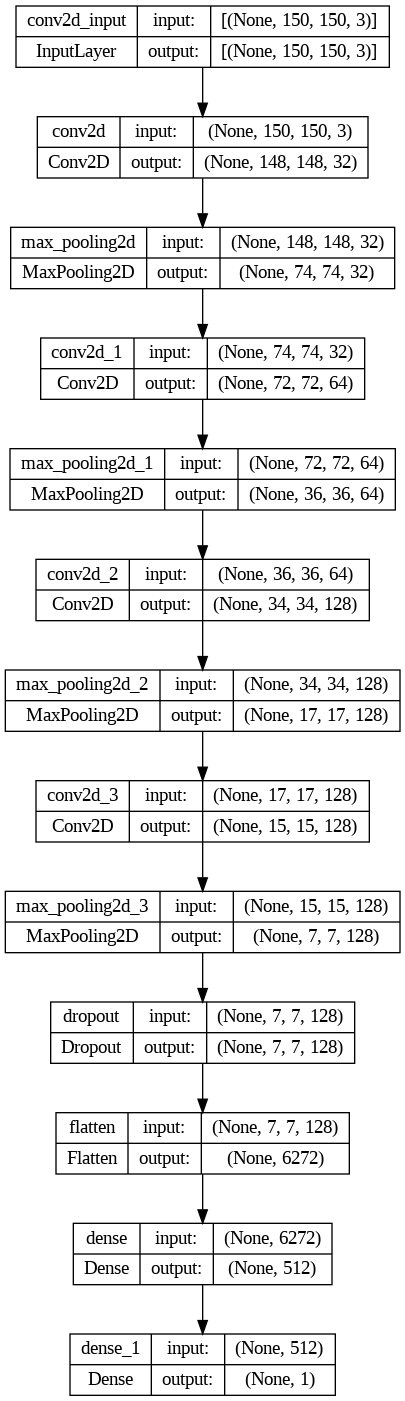

In [19]:
from tensorflow.keras.utils import plot_model

# Plot the model and save it to a file
plot_model(model, to_file='model.png', show_shapes=True)


In [20]:
model.save_weights('model_weights.h5')


In [21]:
model.load_weights('model_weights.h5')


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [23]:
!mkdir /content/runs


In [24]:
!cp -r /content/runs '/content/gdrive/MyDrive/Crime'


In [ ]:
new_model = tf.keras.models.load_model('1682348112.h5')
results = new_model.evaulate(train_generator)